In [62]:
import numpy as np
import requests
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


from tqdm import tqdm
from itertools import product
import datetime as dt
from numpy.linalg import LinAlgError
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
from statsmodels.tsa.api import VARMAX

with pd.HDFStore('arima.h5') as store:
    sarimax_results = store.get('sarimax')

def test_unit_root(df):
    return df.apply(lambda x: f'{pd.Series(adfuller(x)).iloc[1]:.2%}').to_frame('p-value')


#Very useful plot to check for stationarity
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)




headers = {
    'User-Agent' : 'My User Agent 1.0',
    'From': 'cjamesc2399@gmail.com'  
}


url = 'https://prices.runescape.wiki/api/v1/osrs/mapping'

response = requests.get(url,headers=headers)

json = response.json()


#Mapping Dataframe
df = pd.DataFrame(json)
map_df = df[['id','name', 'value']]
map_df['id'] = map_df['id'].astype(str)
map_df.drop(columns = {'value'},inplace= True)

In [63]:
#Data cleaning / formatting

nest = '6693'
bones = '536'#,'536', '6812','6729','22124','3125','22783','22786','21975']
shark = '383'


bones_df = pd.DataFrame()

url = 'https://prices.runescape.wiki/api/v1/osrs/timeseries?timestep=24h&id=' + shark
# Fetch data from the API
response = requests.get(url,headers=headers)
data = response.json()
df= data['data']
df = pd.DataFrame(df)
bones_df= bones_df.append(df)


#dt = datetime.datetime.fromtimestamp(unix_timestamp)



df= bones_df
df['date'] = pd.to_datetime(df['timestamp'], unit='s')

# Extract year, month, day, and hour into separate columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour

# Optionally, drop the 'date' column if it's no longer needed


df.set_index('date',inplace=True)
df = df.drop(columns={'hour','timestamp','year','month','day'} )



Variable Engineering

In [64]:
#Will try to create a few variables from the given data to extract as much of the underlying trend as possible

df['spread'] = df['avgHighPrice'] - df['avgLowPrice']

#Weighted prices
df['w_lowPrice'] = (df['avgLowPrice'] *df['lowPriceVolume']) / (df['lowPriceVolume']+ df['highPriceVolume'])
df['w_highPrice'] = (df['avgHighPrice'] *df['highPriceVolume']) / (df['highPriceVolume']+ df['lowPriceVolume'])

#volume imbalance
df['imbalance']  = (df['highPriceVolume'] - df['lowPriceVolume'])

# #momentum
# df['low_Momentum'] = df['avgLowPrice'] - df['avgLowPrice'].shift(-1)
# df['high_Momentum'] = df['avgHighPrice'] - df['avgHighPrice'].shift(-1)
# df['low_Momentum'] = df['low_Momentum'].fillna(0)
# df['high_Momentum'] = df['high_Momentum'].fillna(0)
#price to volume
df['low_p2vol'] = df['avgLowPrice'] / df['lowPriceVolume'] 
df['high_p2vol'] = df['avgHighPrice'] / df['highPriceVolume']

#Relative Stength Index


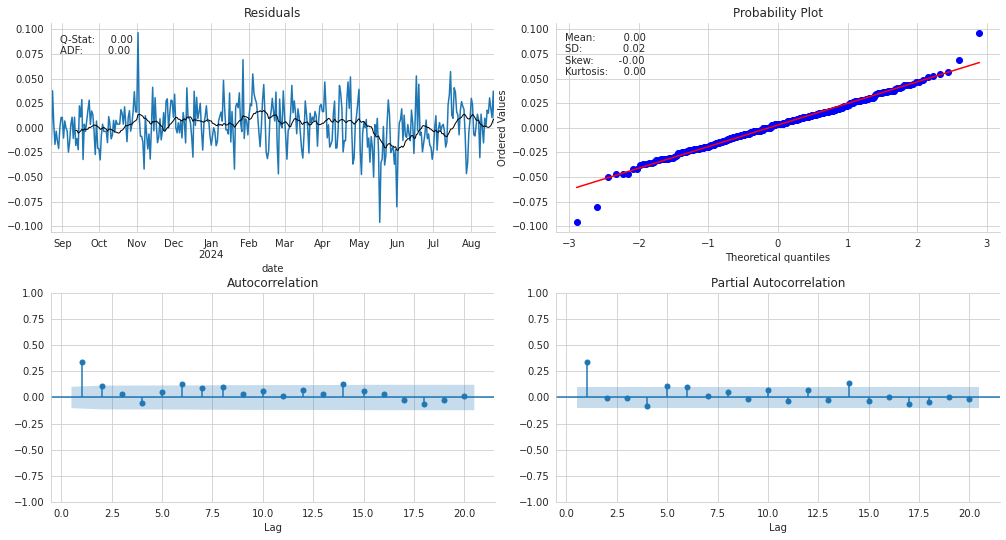

In [65]:

df_copy = df.copy()
df_log = np.log(df)

#choose variable to predict
#is univariate so for now can only use one
model_data = df_log['avgLowPrice']

#difference if necessary
model_data = model_data.diff().dropna()

plot_correlogram(model_data, lags =20)

In [66]:


train_size = 200
results = {}
y_true = model_data.iloc[train_size:]
for p in range(6):
    for q in range(6):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(model_data)):
            train_set = model_data.iloc[T-train_size:T]
            try:
                model = tsa.ARIMA(endog=train_set, order=(p,2, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1

            forecast = model.forecast(steps=1)
            y_pred.append(forecast.iloc[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        results[(p, q)] = [rmse,
                           np.mean(aic),
                           np.mean(bic),
                           convergence_error,
                           stationarity_error]

0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
2 5
3 0
3 1
3 2
3 3
3 4
3 5
4 0
4 1
4 2
4 3
4 4
4 5
5 0
5 1
5 2
5 3
5 4
5 5


In [67]:
arma_results = pd.DataFrame(results).T
arma_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
arma_results.index.names = ['p', 'q']
arma_results

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
0 1  0.025410 -868.635881 -862.059347          0.0           0.0
  2  0.023537 -925.766719 -915.901918          0.0           0.0
  3  0.022559 -940.201162 -927.048094          0.0           0.0
  4  0.022663 -938.064789 -921.623453          0.0           0.0
  5  0.023064 -935.093098 -915.363496          0.0           0.0
1 0  0.033700 -760.079837 -753.503303          0.0           0.0
  1  0.025035 -887.147342 -877.282541          0.0           0.0
  2  0.025678 -866.738106 -853.585038          0.0           0.0
  3  0.023647 -923.897449 -907.456113          0.0           0.0
  4  0.022848 -936.974481 -917.244879          0.0           0.0
  5  0.022352 -934.534913 -911.517044          0.0           0.0
2 0  0.032131 -810.151764 -800.286963          0.0           0.0
  1  0.024760 -899.534268 -886.381200          0.0           0.0
  2  0.023990 -907.240072 -890.798737          0.0           0.0
  3  0.023163 -901.039558 -881.309956          0.0           0.0
  4  0.023772 -923.323985 -900.306116          0.0           0.0
  5  0.022560 -934.489432 -908.183296          0.0           0.0
3 0  0.031540 -817.148045 -803.994977          0.0           0.0
  1  0.024512 -900.252083 -883.810748          0.0           0.0
  2  0.024885 -896.767674 -877.038071          0.0           0.0
  3  0.025524 -891.684885 -868.667016          0.0           0.0
  4  0.024008 -908.169443 -881.863307          0.0           0.0
  5  0.023500 -918.372726 -888.778323          0.0           0.0
4 0  0.029096 -837.402510 -820.961175          0.0           0.0
  1  0.023032 -918.545811 -898.816209          0.0           0.0
  2  0.024804 -897.433170 -874.415301          0.0           0.0
  3  0.025014 -896.027106 -869.720969          0.0           0.0
  4  0.024348 -894.426374 -864.831971          0.0           0.0
  5  0.023065 -909.480847 -876.598177          0.0           0.0
5 0  0.027863 -854.790832 -835.061230          0.0           0.0
  1  0.023527 -916.956807 -893.938937          0.0           0.0
  2  0.022975 -917.565416 -891.259280          0.0           0.0
  3  0.023781 -904.953079 -875.358675          0.0           0.0
  4  0.024407 -904.179558 -871.296888          0.0           0.0
  5  0.023334 -910.380933 -874.209996          0.0           0.0

In [71]:
arma_results.rank().loc[:, ['RMSE', 'AIC']].mean(1).nsmallest(5)

p  q
0  3    1.5
   4    3.0
1  5    3.0
   4    4.0
2  5    4.5
dtype: float64

In [69]:

best_p, best_q = arma_results.rank().loc[:, ['RMSE', 'AIC']].mean(1).idxmin()

In [75]:
best_arma_model = tsa.ARIMA(endog=model_data, order=(best_p,2, best_q)).fit()
print(best_arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:            avgLowPrice   No. Observations:                  364
Model:                 ARIMA(0, 2, 3)   Log Likelihood                 880.375
Date:                Wed, 21 Aug 2024   AIC                          -1752.750
Time:                        18:54:39   BIC                          -1737.183
Sample:                    08-23-2023   HQIC                         -1746.562
                         - 08-20-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.6586      0.097    -17.184      0.000      -1.848      -1.469
ma.L2          0.3818      0.113      3.367      0.001       0.160       0.604
ma.L3          0.2769      0.050      5.508      0.0

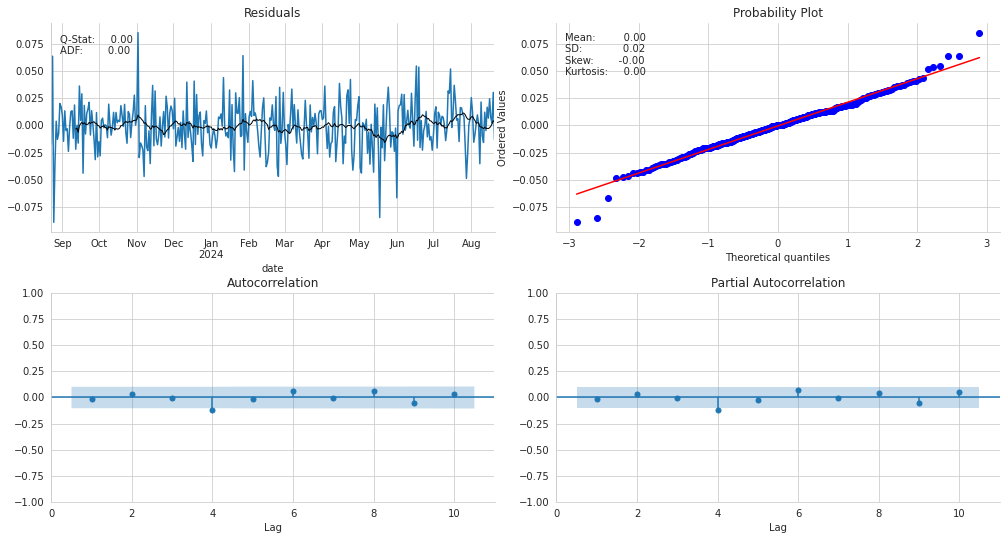

In [76]:
plot_correlogram(best_arma_model.resid)

In [116]:
best_model = tsa.SARIMAX(endog=model_data, order=(best_p, 2, best_q),
                         seasonal_order=(2, 1, 0, 7)).fit()

print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        avgLowPrice   No. Observations:                  364
Model:             SARIMAX(0, 2, 3)x(2, 1, [], 7)   Log Likelihood                 811.841
Date:                            Wed, 21 Aug 2024   AIC                          -1611.683
Time:                                    19:21:01   BIC                          -1588.450
Sample:                                08-23-2023   HQIC                         -1602.440
                                     - 08-20-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.6301      0.052    -31.090      0.000      -1.733      -1.527
ma.L2          0.2925      0.101   

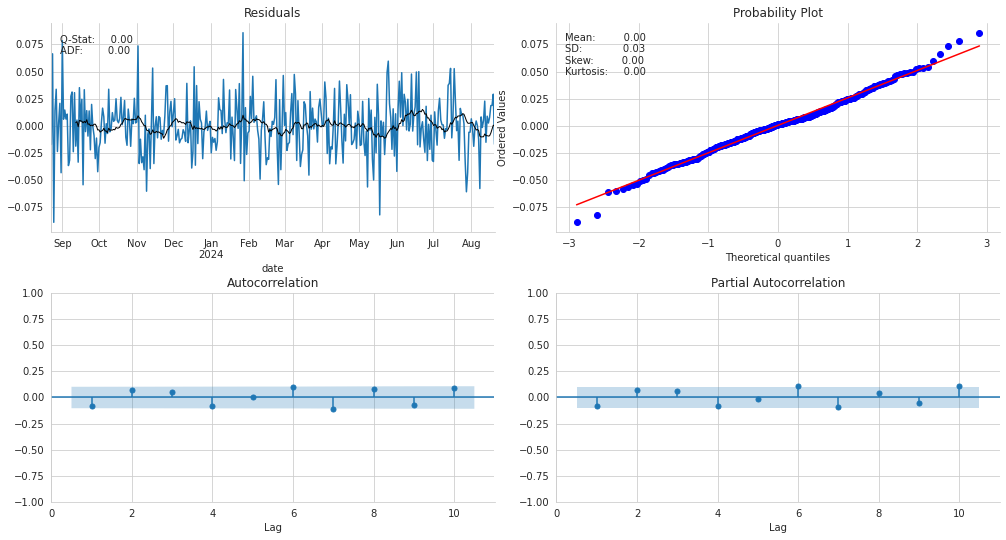

In [117]:
plot_correlogram(pd.Series(best_model.resid))

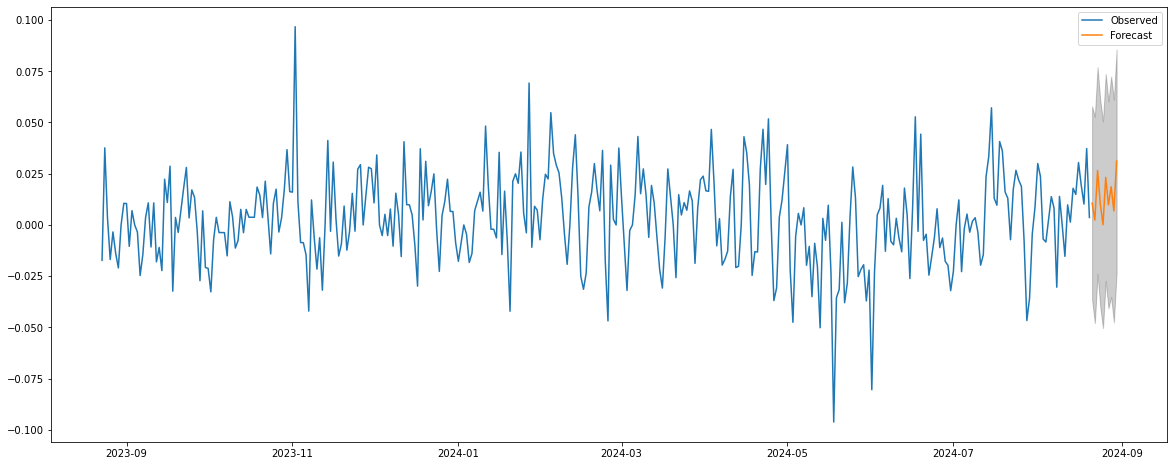

In [118]:
forecast = best_model.get_forecast(steps=10)
forecast_ci = forecast.conf_int()
plt.figure(figsize = (20,8))
# Plot forecast
plt.plot(model_data, label='Observed')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='k', alpha=0.2)
plt.legend()
plt.show()

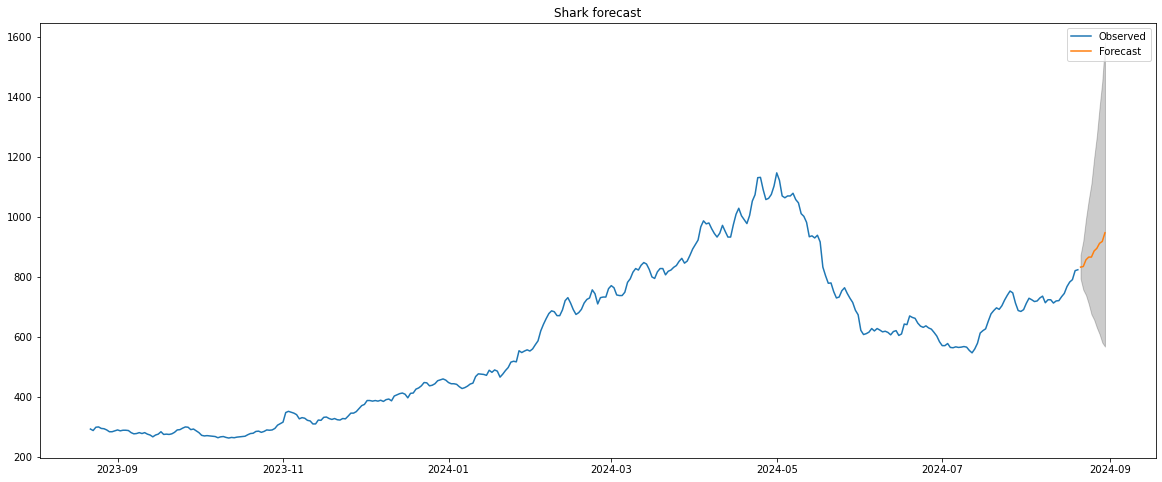

In [125]:
last_actual_value = df_log['avgLowPrice'].iloc[-1]
forecast_reversed_diff = forecast.predicted_mean.cumsum() + last_actual_value

# Step 2: Reverse Log Transformation
forecast_final = np.exp(forecast_reversed_diff)

# If you want to include the confidence intervals:
forecast_ci_reversed_diff = forecast_ci.cumsum() + last_actual_value
forecast_ci_final = np.exp(forecast_ci_reversed_diff)



# Plotting the final results
plt.figure(figsize = (20,8))
plt.plot(df['avgLowPrice'], label='Observed')  # Original data
plt.plot(forecast_final, label='Forecast')  # Forecast data
plt.fill_between(forecast_ci_final.index,
                 forecast_ci_final.iloc[:, 0],
                 forecast_ci_final.iloc[:, 1], color='k', alpha=0.2)
plt.title('Shark forecast')
plt.legend()
plt.show()